In [ ]:
#baut mir ein template waveform / transient

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

plt.style.use('../human_adrenals.mplstyle')



def exponential_decay(t, a, tau, c):
    """Exponential decay function for template creation"""
    return a * np.exp(-t/tau) + c

def create_template(length=500, tau_slow=200, tau_fast=10, rise_time=100, linear_rise=50):
    """
    Create a synthetic calcium transient template with a gradual rise.
    """
    t = np.arange(length)
    template = np.zeros(length)

    # Small Linear Rise
    template[:linear_rise] = np.linspace(0, 0.1, linear_rise)

    # Fast exponential rise
    exp_rise = (1 - np.exp(-(t[linear_rise:rise_time]-t[linear_rise]) / tau_fast))
    template[linear_rise:rise_time] = 0.1 + 0.9*exp_rise

    # Slow Exponential Decay
    template[rise_time:] = np.exp(-(t[rise_time:] - rise_time) / tau_slow)
    return template

def extract_template(signal, onset_idx, window_size):
    """
    Extract a template from a real transient

    Parameters:
    -----------
    signal : array-like
        Source signal
    onset_idx : int
        Start index of transient
    window_size : int
        Length of template to extract
    """
    if onset_idx + window_size > len(signal):
        return None
    template = signal[onset_idx:onset_idx+window_size]
    return (template - np.mean(template)) / np.std(template)

def normalize_signal(signal, window_size=1000):
    """
    Normalize signal in a sliding window

    Parameters:
    -----------
    signal : array-like
        Signal to normalize
    window_size : int
        Size of sliding window
    """
    normalized = np.zeros_like(signal, dtype=float)
    for i in range(len(signal)):
        start = max(0, i - window_size//2)
        end = min(len(signal), i + window_size//2)
        window = signal[start:end]
        normalized[i] = (signal[i] - np.mean(window)) / np.std(window)
    return normalized

def find_matches(signal, template, threshold=0.2, min_distance=50):
    """
    Find template matches in signal

    Parameters:
    -----------
    signal : array-like
        Signal to analyze
    template : array-like
        Template to match
    threshold : float
        Correlation threshold
    min_distance : int
        Minimum frames between matches
    """
    # Compute normalized cross-correlation
    correlation = correlate(signal, template, mode='valid')
    correlation = correlation / len(template)

    # Find peaks in correlation that exceed threshold
    matches = []
    last_match = -min_distance

    for i in range(1, len(correlation)-1):
        if (correlation[i] > threshold and
            correlation[i] > correlation[i-1] and
            correlation[i] > correlation[i+1] and
            i - last_match >= min_distance):
            matches.append(i)
            last_match = i

    return matches, correlation

def calculate_fwhm_function(signal, hysteresis=0.01):
    """
    Calculate Full Width at Half Maximum (FWHM) of a signal with Hysteresis

    Parameters:
    -----------
    signal : array-like
        Signal segment to analyze
    hysteresis : float
        Required difference across the half max level
    """

    half_max = (np.max(signal) - np.min(signal)) / 2.0
    half_max_level = np.min(signal) + half_max

    # Find indices where signal crosses half_max_level + Hysteresis
    above_half_max = signal >= (half_max_level + hysteresis)
    crossings = np.diff(above_half_max.astype(int))
    rising_idx = np.where(crossings == 1)[0]
    falling_idx = np.where(crossings == -1)[0]

    if len(rising_idx) == 0 or len(falling_idx) == 0:
        return None, None, None

    rising_idx = rising_idx[0]
    falling_idx = falling_idx[-1]

    return rising_idx, falling_idx, half_max_level

def fit_exponential_decay(signal, peak_idx):
    """
    Fit an exponential decay to the signal and calculate the time constant

    Parameters:
    -----------
    signal : array-like
        Signal segment to analyze
    peak_idx : int
        Index of the peak in the signal
    """
    decay_phase = signal[peak_idx:]
    t = np.arange(len(decay_phase))

    # Initial guess for parameters
    p0 = (decay_phase[0], 50, decay_phase[-1])

    try:
        params, _ = curve_fit(exponential_decay, t, decay_phase, p0=p0)
        return params[1]  # Return the time constant tau
    except RuntimeError:
        return None

def analyze_calcium_signals(data_file, template=None, threshold=0.7, min_distance=50,
                            calculate_fwhm=False, calculate_time_constants=False, savgol_params=(11,2)):
    """
    Analyze calcium signals using pattern matching

    Parameters:
    -----------
    data_file : str or DataFrame
        Path to CSV file or DataFrame containing calcium measurements
    template : array-like, optional
        Custom template to use. If None, creates synthetic template
    threshold : float
        Correlation threshold for detection
    min_distance : int
        Minimum frames between detections
    calculate_fwhm : bool
        Whether to calculate FWHM for each transient
    calculate_time_constants : bool
        Whether to calculate time constants for each transient
    """
    # Load data
    if isinstance(data_file, str):
        df = pd.read_csv(data_file, index_col=0)
    else:
        df = data_file.copy()

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    signals = df[numeric_cols]

    # Create template if not provided
    if template is None:
        template = create_template()*3

    results = {}

    for column in signals.columns:
        # Get raw signal
        raw_signal = signals[column].values

        # Smooth and normalize signal
        smoothed = savgol_filter(raw_signal, savgol_params[0], savgol_params[1])
        normalized = normalize_signal(smoothed)

        # Find matches
        matches, correlation = find_matches(normalized, template, threshold, min_distance)

        # Analyze each match
        transients = []
        for onset in matches:
            # Define analysis window
            window_end = min(onset + len(template), len(smoothed))
            transient_region = smoothed[onset:window_end]

            # Find peak
            peak_idx = onset + np.argmax(transient_region[:min(50, len(transient_region))])

            # Store information
            transient_info = {
                'onset_frame': onset,
                'peak_frame': peak_idx,
                'correlation': correlation[onset],
                'amplitude': smoothed[peak_idx] - smoothed[onset]
            }

            if calculate_fwhm:
                rising_idx, falling_idx, half_max_level = calculate_fwhm_function(transient_region)
                if rising_idx is not None and falling_idx is not None and half_max_level is not None:  #Add check for half_max_level
                    transient_info['fwhm_start'] = onset + rising_idx
                    transient_info['fwhm_end'] = onset + falling_idx
                    transient_info['fwhm'] = transient_info['fwhm_end']-transient_info['fwhm_start']
                    transient_info['half_max_level'] = half_max_level
                else:
                    transient_info['fwhm_start'] = None
                    transient_info['fwhm_end'] = None
                    transient_info['half_max_level'] = None


            if calculate_time_constants:
                rise_time_constant = fit_exponential_decay(transient_region[:peak_idx], np.argmax(transient_region[:peak_idx]))
                decay_time_constant = fit_exponential_decay(transient_region[peak_idx:], 0)
                transient_info['rise_time_constant'] = rise_time_constant
                transient_info['decay_time_constant'] = decay_time_constant

            transients.append(transient_info)

        # Store results
        results[column] = {
            'raw_signal': raw_signal,
            'smoothed': smoothed,
            'normalized': normalized,
            'correlation': np.pad(correlation, (0, len(template)-1), mode='constant'),
            'threshold': np.ones_like(raw_signal) * threshold,
            'template': template,
            'transients': transients
        }

    return results

def create_average_template_from_transient_numbers(results, cell_name, transient_numbers, window_length=100):
    """
    Creates an average template from specified transient numbers.

    Parameters:
    -----------
    results : dict
        Dictionary of analysis results from `analyze_calcium_signals`
    cell_name : str
        Name of the cell to extract transients from
    transient_numbers : list
        List of transient numbers (1-based index) to average
    window_length : int
        Length of the template window in frames
    """

    if cell_name not in results:
        print(f"Error: Cell '{cell_name}' not found in results.")
        return None

    cell_data = results[cell_name]
    transients = cell_data['transients']

    if not transients:
        print(f"Error: No transients found for cell '{cell_name}'.")
        return None

    templates = []
    for transient_number in transient_numbers:
        if 1 <= transient_number <= len(transients):
            transient = transients[transient_number - 1] # Convert to 0-based indexing

            # Make sure the window doesn't go past the data:
            onset_idx = transient['onset_frame']
            if onset_idx + window_length <= len(cell_data['smoothed']):
                template = extract_template(cell_data['smoothed'], onset_idx, window_length)
                if template is not None:
                    templates.append(template)
            else:
                print(f"Warning: Transient {transient_number} for cell '{cell_name}' exceeds data boundaries. Skipping.")
        else:
            print(f"Warning: Invalid transient number {transient_number} for cell '{cell_name}'. Skipping.")

    if not templates:
        print(f"Error: No valid templates found for averaging. Check transient numbers and data boundaries.")
        return None

    # Stack templates and average
    stacked = np.stack(templates)
    return np.mean(stacked, axis=0)

def plot_analysis(results, cell_name, figsize=(12, 10)):
    """Plot pattern matching analysis results"""
    import matplotlib.pyplot as plt

    cell_data = results[cell_name]

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize, height_ratios=[2, 1, 1])

    # Plot signal and detections
    ax1.plot(cell_data['raw_signal'], 'k-', alpha=0.5, label='Raw Signal')
    ax1.plot(cell_data['smoothed'], 'b-', label='Smoothed')

    # Mark detections
    colors = plt.cm.rainbow(np.linspace(0, 1, len(cell_data['transients'])))
    for i, transient in enumerate(cell_data['transients']):
        # Highlight the transient region
        ax1.axvspan(transient['onset_frame'], transient['onset_frame'] + len(cell_data['template']),
                    facecolor=colors[i], alpha=0.15, label=f'Match {i+1}' if i == 0 else '')

        ax1.axvline(transient['onset_frame'], color=colors[i], linestyle=':',
                   alpha=0.5) #Remove label to unclutter plot
        ax1.axvline(transient['peak_frame'], color=colors[i], linestyle='--',
                   alpha=0.5) #Remove label to unclutter plot

        # Plot FWHM line
        if 'fwhm_start' in transient and transient['fwhm_start'] is not None and transient['fwhm_end'] is not None and transient['half_max_level'] is not None:
            ax1.hlines(transient['half_max_level'], transient['fwhm_start'], transient['fwhm_end'],
                       color=colors[i], linewidth=2, label='FWHM' if i == 0 else '')

    ax1.set_title(f'Pattern Matching Analysis - {cell_name}\n' +
                 f'Number of matches: {len(cell_data["transients"])}')
    ax1.set_ylabel('Fluorescence')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot normalized signal
    ax2.plot(cell_data['normalized'], 'g-', label='Normalized Signal')
    ax2.set_ylabel('Normalized')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot correlation and threshold
    ax3.plot(cell_data['correlation'], 'r-', label='Correlation')
    ax3.plot(cell_data['threshold'], 'k--', label='Threshold')
    ax3.set_xlabel('Frame')
    ax3.set_ylabel('Correlation')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Insert template as inset
    #template_ax = fig.add_axes([0.15, 0.65, 0.2, 0.1])
    #template_ax.plot(cell_data['template'], 'b-')
    #template_ax.set_title('Template')

    plt.tight_layout()
    plt.show()

def print_match_summary(results, cell_name):
    """Print summary of template matches"""
    cell_data = results[cell_name]
    print(f"\nMatch Summary for {cell_name}:")
    print("-" * 50)
    for i, transient in enumerate(cell_data['transients']):
        print(f"\nMatch {i+1}:")
        print(f"Onset frame: {transient['onset_frame']}")
        print(f"Peak frame: {transient['peak_frame']}")
        print(f"Correlation: {transient['correlation']:.3f}")
        print(f"Amplitude: {transient['amplitude']:.1f}")
        if 'fwhm_start' in transient and transient['fwhm_start'] is not None and transient['fwhm_end'] is not None:
            print(f"FWHM Start: {transient['fwhm_start']}")
            print(f"FWHM End: {transient['fwhm_end']}")
            print(f"FWHM: {transient['fwhm']}")
        if 'rise_time_constant' in transient:
            print(f"Rise Time Constant: {transient['rise_time_constant']:.1f}")
        if 'decay_time_constant' in transient:
            print(f"Decay Time Constant: {transient['decay_time_constant']:.1f}")


In [ ]:
# ----------CONFIG-------------------

recording_list = ["Slice01_Rec01_Fura-2_Ratio.csv",
                 "Slice01_Rec02_Fura-2_Ratio.csv"]


results = {x:{} for x in recording_list}
for recording in recording_list:

    # Basic usage with synthetic template
    results[recording]=analyze_calcium_signals(recording, 
                                threshold=1,
                                min_distance=300,
                                calculate_fwhm=True, savgol_params=(48,2))



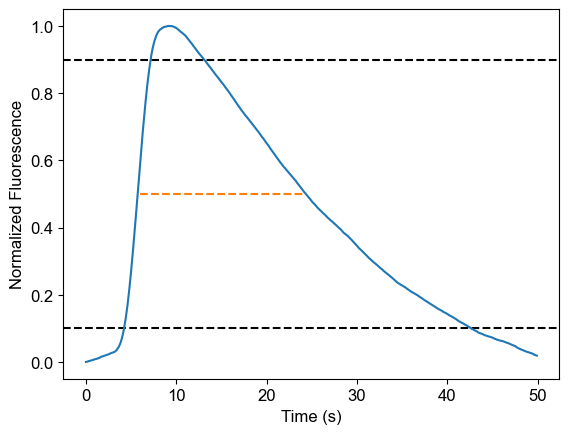

In [ ]:

good_transients = {"Mean1": [1,2,3,4],
                  "Mean2": [2,3,4],
                  "Mean3": [1],
                  "Mean4": [1,2,3],
                  "Mean6": [1,2,3],
                  "Mean7": [2,3,4],
                  "Mean9": [1,2],
                  "Mean12": [2,3,4]}

average_transient = []

for cell in good_transients.keys():
    average_transient.append(create_average_template_from_transient_numbers(results["Slice01_Rec01_Fura-2_Ratio.csv"], 
                                                   cell, good_transients[cell], window_length=500))

    
average_transient = np.mean(average_transient, axis=0)
average_transient = average_transient - np.min(average_transient)
average_transient = average_transient/np.max(average_transient)

plt.figure()
plt.axhline(0.1, color="black", ls="--")
plt.axhline(0.9, color="black", ls="--")
plt.plot(np.arange(0, len(average_transient)/10, 0.1), average_transient)
plt.plot([6, 24], [0.5, 0.5], ls="--")

plt.xlabel("Time (s)")
plt.ylabel("Normalized Fluorescence")
plt.savefig("Fura-2_template.svg")
plt.show()

np.savetxt("Fura-2_template.csv", average_transient, delimiter=",")
